### Transfer Learning with Tensorflow Part 3: Scaling up (Food vision mini)

we've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).


Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).


Original Food101 paper:https://link.springer.com/chapter/10.1007/978-3-319-10599-4_29

our baseline to beat is 50.76% accuracy across 101 classes.

#### import helper functions


In previous notebooks, we've created a series of helper functions to do different tasks, let's import them

In [1]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir

#### 101 Food classes: working with less data

our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from original Food101 dataset but has been preprocessed to use less data

In [2]:
### download the data

import wget
url="https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
filename=wget.download(url)
print(filename)

  0% [                                                                    ]    1024000 / 1625420029

  0% [                                                                    ]    2547712 / 1625420029

  0% [                                                                    ]    4194304 / 1625420029

  0% [                                                                    ]    5603328 / 1625420029

100% [....................................................................] 1625420029 / 1625420029101_food_classes_10_percent.zip


In [3]:
#unzip the data
unzip_data("101_food_classes_10_percent.zip")

In [4]:
#setup the training and test dir path

train_dir="101_food_classes_10_percent/train"
test_dir="101_food_classes_10_percent/test"

In [5]:
#How many images/classes are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [7]:
#setup data inputs

import tensorflow as tf
IMG_SIZE=(224,224)
train_data_101_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                             image_size=IMG_SIZE,
                                                                             label_mode="categorical")

test_data_101_10_percent=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            shuffle=False)  #don't shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


#Train a big model withtransfer learning on 10% of 101 food classes


Here are the steps we'r going to take
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (on Top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full classes (5 epochs on the Train dataset and validate on 15% of the test data, to save epoch time

In [8]:
#Create a checkpoint callback
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      monitor="val_accuracy",
                                                      save_best_only=True)

In [11]:
#Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Setup data augmentation
data_augmentation=Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescalling(1/255.)  #res
],name="data_augmentation")

In [16]:
#setup the base mode and frezze it's layer (this will extract features)

base_model=tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable=False

#setup model archtecture with trainable top layers
inputs=layers.Input(shape=(224,224,3),name="input_layer")

x=data_augmentation(inputs)  #augment images (only during training phase)
x=base_model(x,training=False)  # put the base model in inference mode so weights which need to stay frozen,stay frozen
x=layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs=layers.Dense(len(train_data_101_10_percent.class_names),activation="softmax",name="output_layer")(x)

model=tf.keras.Model(inputs,outputs)


In [17]:
#Get the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [19]:
#Compile the model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [20]:
#Fit the model
history_all_classes_10_percent=model.fit(train_data_101_10_percent,
                                        epochs=5,
                                        #steps_per_epoch=len(train_data_101_10_percent),
                                        validation_data=test_data_101_10_percent,
                                        validation_steps=int(0.15*len(test_data_101_10_percent)),
                                        callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 62s 207ms/step - loss: 3.3834 - accuracy: 0.2727 - val_loss: 2.5520 - val_accuracy: 0.4208
Epoch 2/5
237/237 [==============================] - 47s 198ms/step - loss: 2.2072 - accuracy: 0.4976 - val_loss: 2.0902 - val_accuracy: 0.4918
Epoch 3/5
237/237 [==============================] - 46s 194ms/step - loss: 1.8164 - accuracy: 0.5710 - val_loss: 1.9230 - val_accuracy: 0.5146
Epoch 4/5
237/237 [==============================] - 49s 206ms/step - loss: 1.5960 - accuracy: 0.6150 - val_loss: 1.8090 - val_accuracy: 0.5283
Epoch 5/5
237/237 [==============================] - 51s 215ms/step - loss: 1.4457 - accuracy: 0.6483 - val_loss: 1.7840 - val_accuracy: 0.5299


In [21]:
#evaluate on whole test dataset
fine_tuning_results=model.evaluate(test_data_101_10_percent)

790/790 [==============================] - 41s 51ms/step - loss: 1.5726 - accuracy: 0.5861


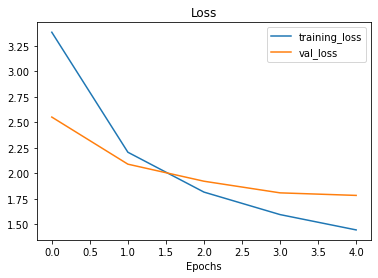

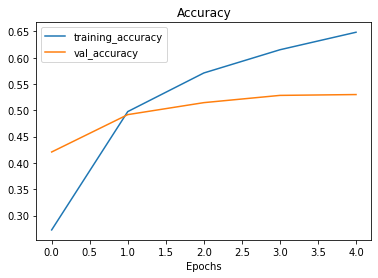

In [22]:
#plot the loss curves
plot_loss_curves(history_all_classes_10_percent)

**Question:** what do these curves suggest? hint: ideally, the two curves shpuld be very similar to each other,if not


if not it may be suggested that our model is overfitting(performing too well on the training data and not generalizing to unseen data).

#### Fine-tuning

In [40]:
#Unfreeze all of the layers in the base model
base_model.trainable=True


#Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable=False

In [39]:
#check which layers are trainable in our base model
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer.name,layer.trainable)

0 input_5 True
1 rescaling_8 True
2 normalization_4 True
3 rescaling_9 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b

In [41]:
#Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine tuning)
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),#learning rate lowere by 10x from default value
              metrics=["accuracy"]
             )

In [42]:
#what layers in the model are trainable?
for layer in model.layers:
    print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [43]:
#check which layers are trainable in our base model
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer.name,layer.trainable)

0 input_5 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [45]:
#fine tune for 5 more epochs
fine_tune_epochs=10 #model has already done 5 epochs (feature extraction), this is the total number of epochs we're after(5+5=10)


#Fine-tune our model
history_all_classes_10_percent_fine_tune=model.fit(train_data_101_10_percent,
                                                  epochs=fine_tune_epochs,
                                                  validation_data=test_data_101_10_percent,
                                                  validation_steps=int(0.15*len(test_data_101_10_percent)),
                                                  initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 54s 208ms/step - loss: 1.2206 - accuracy: 0.6849 - val_loss: 1.7266 - val_accuracy: 0.5323
Epoch 6/10
237/237 [==============================] - 48s 202ms/step - loss: 1.1054 - accuracy: 0.7050 - val_loss: 1.7287 - val_accuracy: 0.5408
Epoch 7/10
237/237 [==============================] - 49s 206ms/step - loss: 1.0203 - accuracy: 0.7269 - val_loss: 1.7242 - val_accuracy: 0.5442
Epoch 8/10
237/237 [==============================] - 48s 201ms/step - loss: 0.9393 - accuracy: 0.7490 - val_loss: 1.7425 - val_accuracy: 0.5403
Epoch 9/10
237/237 [==============================] - 48s 202ms/step - loss: 0.8888 - accuracy: 0.7630 - val_loss: 1.7325 - val_accuracy: 0.5463
Epoch 10/10
237/237 [==============================] - 48s 204ms/step - loss: 0.8344 - accuracy: 0.7735 - val_loss: 1.6863 - val_accuracy: 0.5530


In [47]:
#Evaluate on the all test data
all_classes_10_percent_fine_tune_results=model.evaluate(test_data_101_10_percent)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 40s 51ms/step - loss: 1.4866 - accuracy: 0.6067


[1.4865894317626953, 0.6067326664924622]

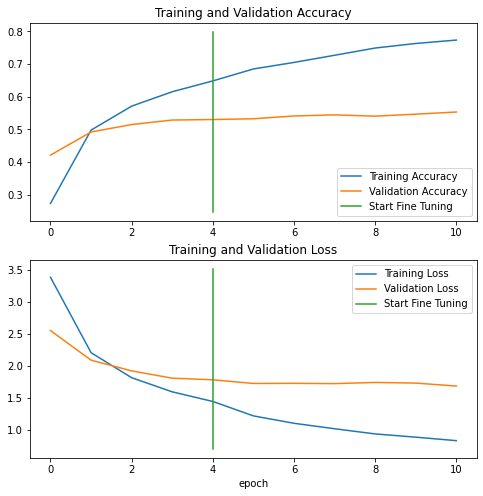

In [48]:
#Compare the histories of feature extraction model with fine tuning
compare_historys(original_history=history_all_classes_10_percent,
                new_history=history_all_classes_10_percent_fine_tune,
                initial_epochs=5)

#### saving and loading our model
To use our model in an external application,we'll need to save it and export it somewhere

In [50]:
#Save our fine-tuning model
model.save("101_food_classes_10_percent_saved_big_model")

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_model\assets


INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_model\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [51]:
#load an evaluate saved model
loaded_model=tf.keras.models.load_model("101_food_classes_10_percent_saved_big_model/")

ValueError: Unable to create a Keras model from SavedModel at 101_food_classes_10_percent_saved_big_model/. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.

In [52]:
#Evaluate loaded model and compare performance to pre-saved model
loaded_model_results=loaded_model.evaluate(test_data_101_10_percent)
loaded_model_results


NameError: name 'loaded_model' is not defined

In [53]:
#The results from our loaded model should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.4865894317626953, 0.6067326664924622]

#### Evaluating the performance of the big dog model across all different classes

Let's make some predictions,visualize them and then later find out which predictions were the "most" wrong predictions


In [54]:
import tensorflow as tf
import wget
url="https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip"
filename=wget.download(url)
print(filename)

100% [........................................................................] 46760742 / 4676074206_101_food_class_10_percent_saved_big_dog_model.zip


In [55]:
#unzip the data
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

**Note:** Loading the model with the following cell will output a large amount of warning, there is a thread tracking this issue on
Github: however it seems according to the Tensorflow documentation, loading warning can be ignored:https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_usage

In [57]:
#Load in saved model
model=tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [59]:
#Evaluate loaded model (the one we just downloaded on test data)

result_downloaded_model=model.evaluate(test_data_101_10_percent)
result_downloaded_model

790/790 [==============================] - 43s 54ms/step - loss: 1.8022 - accuracy: 0.6077


[1.8021550178527832, 0.6077227592468262]

#### Make predictions with our trained model

In [60]:
#Make predictions with model
preds_probs=model.predict(test_data_101_10_percent,verbose=1)  #set verbosity to see how long is left

790/790 [==============================] - 39s 49ms/step


In [61]:
len(test_data_101_10_percent)

790

In [62]:
790*32

25280

In [63]:
#How many predictions are there?
len(preds_probs)

25250

In [65]:
#what's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [66]:
#Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9479523e-02, 3.5853586e-06, 4.1490741e-02, ..., 1.4207630e-09,
        8.4004649e-05, 3.0848435e-03],
       [9.6352184e-01, 1.3794775e-09, 8.5208233e-04, ..., 5.4750224e-05,
        7.8354996e-12, 9.8206399e-10],
       [9.5921791e-01, 3.2627246e-05, 1.4850969e-03, ..., 7.1920647e-07,
        5.5218203e-07, 4.0328752e-05],
       ...,
       [4.7347677e-01, 1.2929389e-07, 1.4723995e-03, ..., 5.9845165e-04,
        6.7310080e-05, 2.3590212e-05],
       [4.4653706e-02, 4.7227482e-07, 1.2216036e-01, ..., 6.3061693e-06,
        7.5868552e-06, 3.6865773e-03],
       [7.2390634e-01, 1.9219288e-09, 5.2392930e-05, ..., 1.2270206e-03,
        1.5755681e-09, 9.6003030e-05]], dtype=float32)

In [68]:
#what does the first prediction look like?
preds_probs[0],len(preds_probs[0]),sum(preds_probs[0])

(array([5.94795235e-02, 3.58535863e-06, 4.14907411e-02, 1.06443321e-09,
        8.21597634e-09, 8.62045724e-09, 8.12979692e-07, 8.48057198e-07,
        1.98268463e-05, 7.99717895e-07, 3.18121263e-09, 9.84326675e-07,
        2.84175127e-04, 7.78855425e-10, 7.44543446e-04, 3.88448570e-05,
        6.46518356e-06, 2.50317476e-06, 3.77090510e-05, 2.05665614e-07,
        1.56468577e-05, 8.11520351e-07, 2.61725222e-06, 2.04193199e-07,
        8.31965281e-07, 5.43475835e-06, 3.74278193e-06, 1.31893811e-08,
        2.74770171e-03, 2.79182077e-05, 6.83966106e-10, 2.54005045e-05,
        1.66685539e-04, 7.61099184e-10, 4.04454739e-04, 1.30887381e-08,
        1.79128733e-06, 1.44443868e-06, 2.31985878e-02, 8.26595397e-07,
        8.64255981e-07, 1.69825512e-06, 7.07225809e-06, 1.86568236e-08,
        2.88067866e-07, 8.00525595e-06, 2.08164670e-06, 1.86232697e-07,
        3.35682238e-08, 3.18711478e-04, 1.05089712e-05, 8.59449358e-07,
        8.47246587e-01, 1.05632098e-05, 4.34800739e-07, 3.733133

our model outputs a prediction probability array (with N number of variables,where N is the number of classes) for each sample passesd to the predict method.

In [71]:
#we get one prediction probability per class(in our case there's 101 prediction probabilies)
print(f"Number of prediction probabilities for sample_0:{len(preds_probs[0])}")
print(f"what prediction probability sample_0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample_0:{preds_probs[0].argmax()}")

Number of prediction probabilities for sample_0:101
what prediction probability sample_0 looks like:
 [5.94795235e-02 3.58535863e-06 4.14907411e-02 1.06443321e-09
 8.21597634e-09 8.62045724e-09 8.12979692e-07 8.48057198e-07
 1.98268463e-05 7.99717895e-07 3.18121263e-09 9.84326675e-07
 2.84175127e-04 7.78855425e-10 7.44543446e-04 3.88448570e-05
 6.46518356e-06 2.50317476e-06 3.77090510e-05 2.05665614e-07
 1.56468577e-05 8.11520351e-07 2.61725222e-06 2.04193199e-07
 8.31965281e-07 5.43475835e-06 3.74278193e-06 1.31893811e-08
 2.74770171e-03 2.79182077e-05 6.83966106e-10 2.54005045e-05
 1.66685539e-04 7.61099184e-10 4.04454739e-04 1.30887381e-08
 1.79128733e-06 1.44443868e-06 2.31985878e-02 8.26595397e-07
 8.64255981e-07 1.69825512e-06 7.07225809e-06 1.86568236e-08
 2.88067866e-07 8.00525595e-06 2.08164670e-06 1.86232697e-07
 3.35682238e-08 3.18711478e-04 1.05089712e-05 8.59449358e-07
 8.47246587e-01 1.05632098e-05 4.34800739e-07 3.73313378e-05
 3.51655290e-05 3.25759102e-05 6.75298288e-0

In [73]:
test_data_101_10_percent.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [74]:
#Get the pred classes of each label
pred_classes=preds_probs.argmax(axis=1)


#How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0], dtype=int64)

In [75]:
#How many pred classes do we have?
len(pred_classes)

25250

Now we've git a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset

In [76]:
test_data_101_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [78]:
#To get our test labels we need unravel our test_data BatchDataset
y_labels=[]
for images,labels in test_data_101_10_percent.unbatch():
    y_labels.append(labels.numpy().argmax())  #currently test labels look like:[0,0,0,1,.....0,0], we want the index value where the '1' occurs
y_labels[:10]   #look at the first 10
    

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [79]:
#How many y_labels are there
len(y_labels)

25250

### Evaluating our model's prediction
one way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [80]:
result_downloaded_model

[1.8021550178527832, 0.6077227592468262]

In [84]:
#Let's try scikit learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy=accuracy_score(y_true=y_labels,
                               y_pred=pred_classes)
sklearn_accuracy

0.6077227722772277

In [83]:
#from tensorflow.keras.metrics import Accuracy

In [85]:
#Does this metric come clos to our model's evaluate results
import numpy as np
np.isclose(result_downloaded_model[1],sklearn_accuracy)

True

### Creating a Confusion Matrix for our 101 classes

In [86]:
from helper_functions import make_confusion_matrix

In [87]:
#Get the list of class names

class_names=test_data_101_10_percent.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

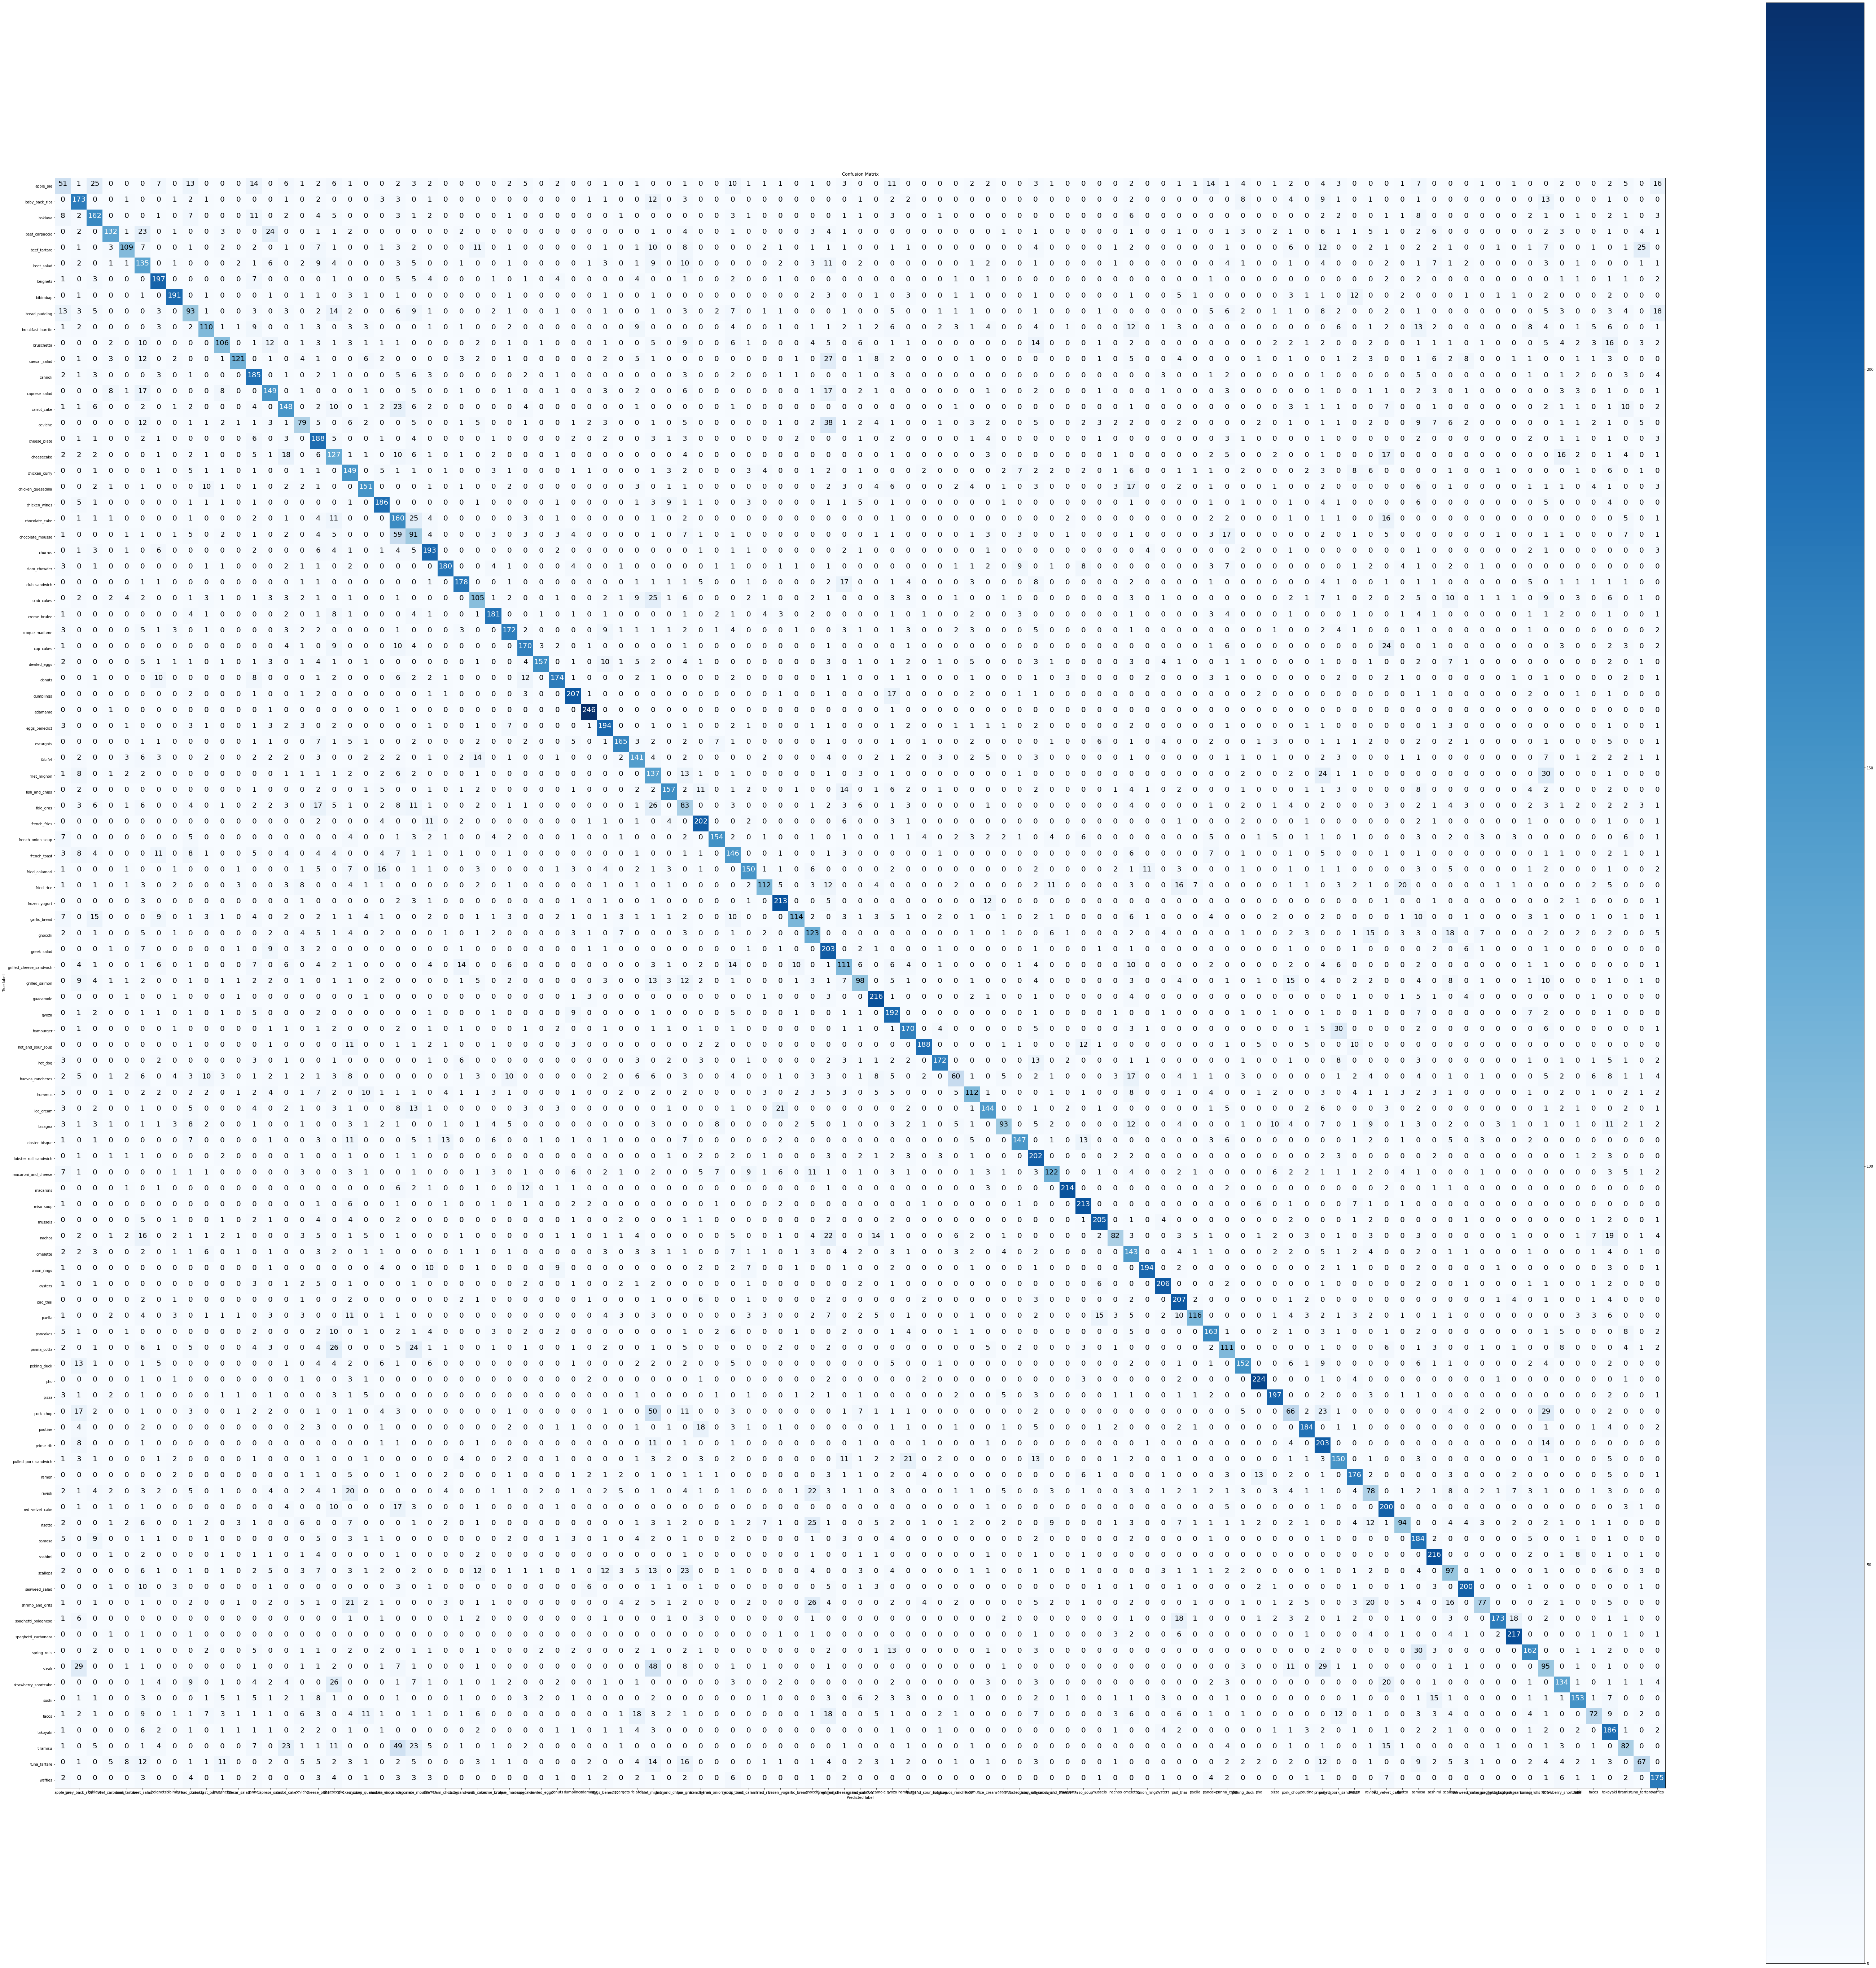

In [89]:
make_confusion_matrix(y_true=y_labels,
                     y_pred=pred_classes,
                     classes=class_names,
                     figsize=(100,100),
                     text_size=20)

In [97]:
#we need to make some changes to our make_confusion_matrix function to ensure the X-labels print vertically
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

      If classes is passed, confusion matrix will be labelled, if not, integer class values
      will be used.

      Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
        norm: normalize values or not (default=False).
        savefig: save confusion matrix to file (default=False).

      Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

      Example usage:
        make_confusion_matrix(y_true=test_labels, # ground truth test labels
                              y_pred=y_preds, # predicted labels
                              classes=class_names, # array of class label names
                              figsize=(15, 15),
                              text_size=10)
    """  
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes), # create enough axis slots for each class
        yticks=np.arange(n_classes), 
        xticklabels=labels, # axes will labeled with class names (if they exist) or ints
        yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    
    #### changed(plot x-labels vertically)##
    plt.xticks(rotation=70,fontsize=text_size)
    plt.yticks(fontsize=text_size)
    
    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                      color="white" if cm[i, j] > threshold else "black",
                      size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)

      # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

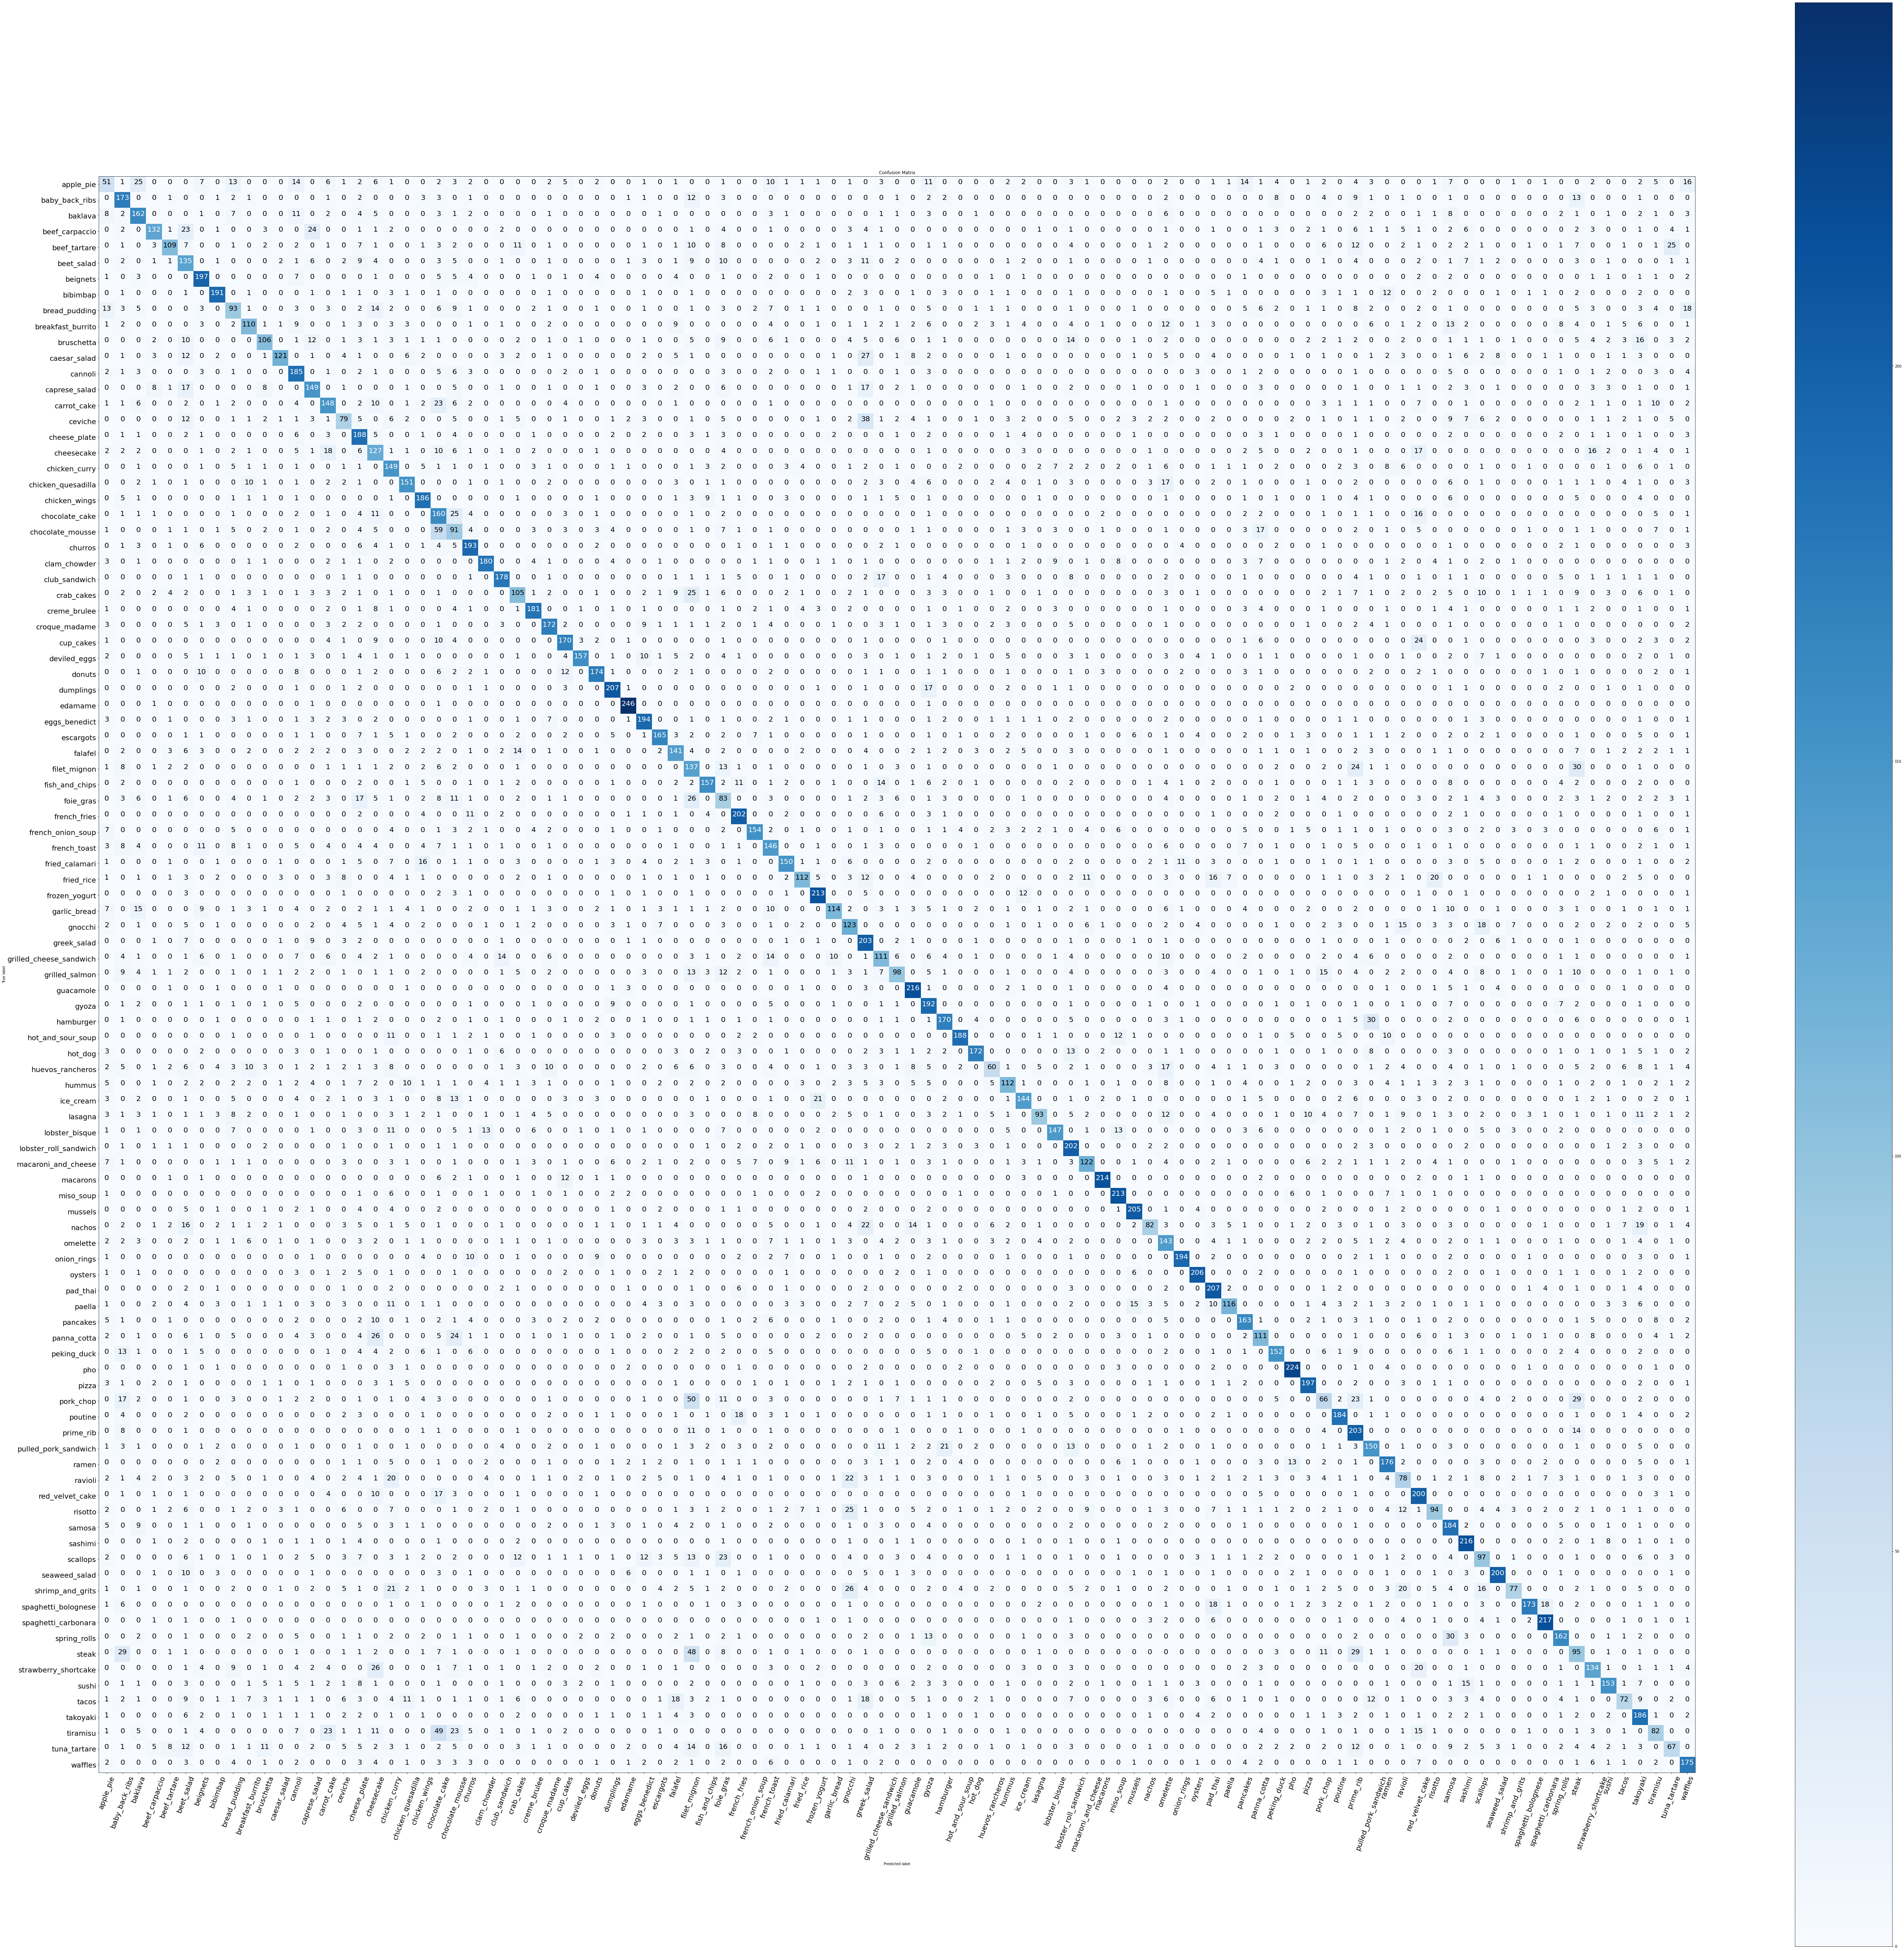

In [99]:
make_confusion_matrix(y_true=y_labels,
                     y_pred=pred_classes,
                     classes=class_names,
                     figsize=(100,100),
                     text_size=20,
                     savefig=True)

#### Evaluating every individual classes in our dataset


##### Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification_report, let's try it out


In [100]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                           y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.74      0.44      0.55       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.52       250
          10       0.62      0.42      0.50       250
          11       0.83      0.48      0.61       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's prediction but with so many classes, they're quite hard to understand

How about we create a visualization to get a better understanding

In [101]:
# get a dictionary of the classification report
classification_report_dict=classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5605536332179931,
  'recall': 0.648,
  'f1-score': 0.601113172541744,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7364864864864865,
  'recall': 0.436,
  'f1-score': 0.5477386934673367,
  'support': 250},
 '5': {'precision': 0.3426395939086294,
  'recall': 0.54,
  'f1-score': 0.4192546583850932,
  'support': 250},
 '6': {'precision': 0.6700680272108843,
  'recall': 0.788,
  'f1-score': 0.724264705882353,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 

In [103]:
class_names[70]

'pad_thai'

Let's plot all of our classes F1-scores

In [107]:
#Create empty dictionary
class_f1_scores={}
#Loop through classification reprt dictionary items
for k,v in classification_report_dict.items():
    if k=="accuracy": # stop once we get to accuracy key
        break
    else:
        #add class names and f1 scores to new_dictionary
        class_f1_scores[class_names[int(k)]]=v['f1-score']
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.601113172541744,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.5477386934673367,
 'beet_salad': 0.4192546583850932,
 'beignets': 0.724264705882353,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5152224824355972,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6126582278481012,
 'cannoli': 0.6135986733001659,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.5736434108527131,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5662650602409639,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7099236641221374,
 'chocolate_cake': 0.45325779036827196,
 'chocolate_mousse': 0.3255813953488372,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.7325102880658436,
 'crab_cakes': 0.46153846153846156,
 'creme_brulee': 0.749482401

In [118]:
#turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores=pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                       "f1-score":list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [119]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.935361
63             macarons  0.897275
75                  pho  0.869903
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
54    hot_and_sour_soup  0.810345

#### ploting our model's F1-scores for each separate class

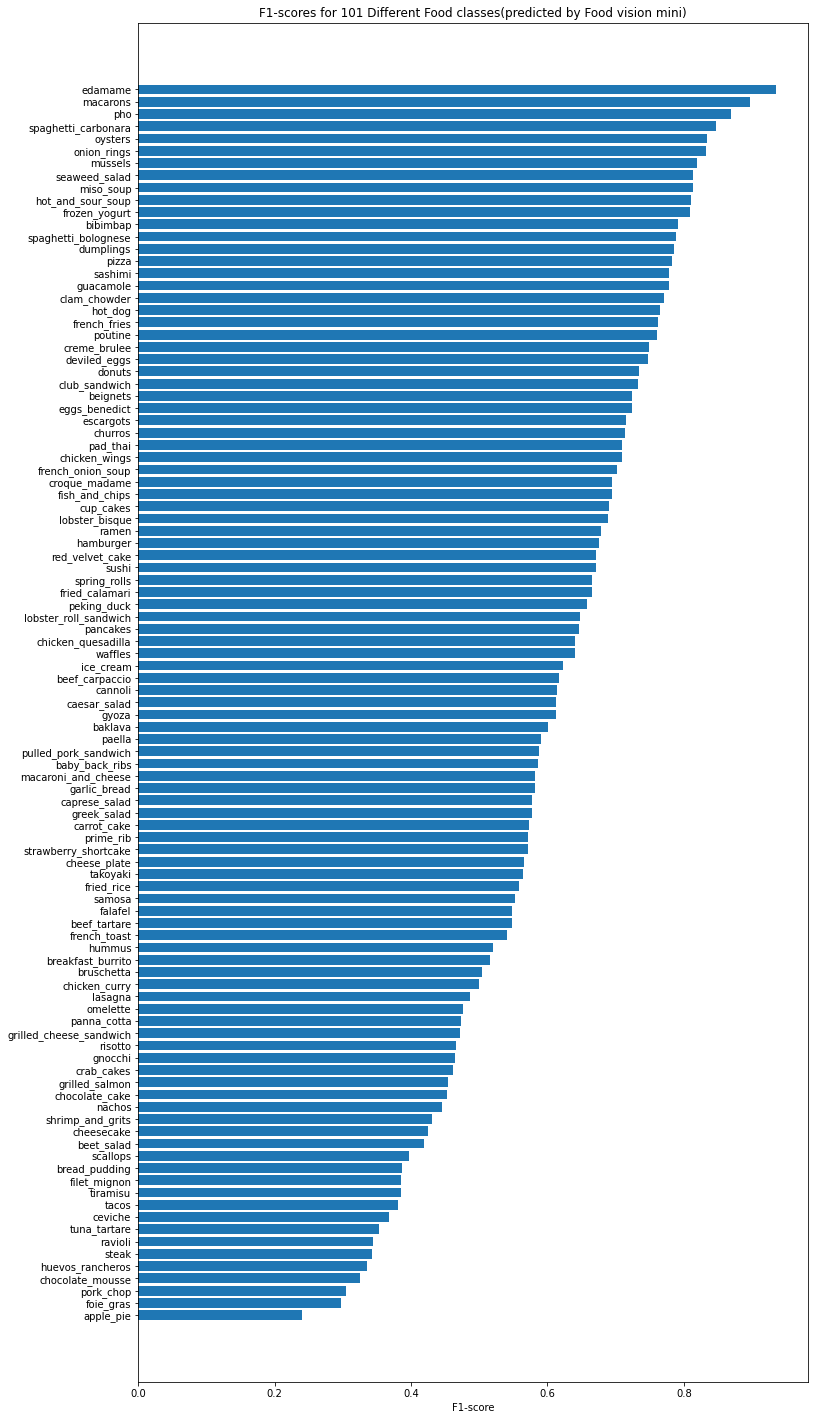

In [122]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(12,25))
scores=ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)  #get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food classes(predicted by Food vision mini)")
ax.invert_yaxis();

#challenge: add values to the end of each bar of the actual f1-score is(hint: use the "autolabel" function from here)


**Task:** Try visualizing some of the most poorly predicted classes (e.g. `apple_pie`,`pork_chip`), do you notice any trends among them? why might our model be having trouble with them?

## Visualizing  predictions on custom images

Now, this is the real test, how does our model go on food images not even in our  test dataset(images of our own,we'll see this later on).

To Visualize our model's predictions on our own images, we'll need a function to lad and preprocess images, specifically it will  need to :
* read in a target image filepath using tf.io.read_file()
* turn the image into a tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 and 1 (if necessary)

In [125]:
#Create a function to load and prepare images
def load_and_prep_image(filename,img_shape=224,scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into specified shape(image_shape,img_shape,color-channels=3).
    
    Args:
        filename (str): path to target image
        image_shape (int): height/width dimension of target image size
        scale (bool): scale pixel values from 0-255 to 0-1 or not
        
    Returns:
        Image tensor of shape (img_shape,img_shape,3)
    """
    #Read in the image
    img=tf.io.read_file(filename)
    
    #Decode image into tensor
    img=tf.io.decode_image(img,channels=3)
    
    
    #Resize the image
    img=tf.image.resize(img,size=[img_shape,img_shape])
    
    
    #scale? yes/no
    if scale:
        #rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img  # don't need to rescale images for Efficientnet models in tensorflow
    

Now we've got a function to load and prepare target images,
let's now write some code to visualize images, their target label and our model's predictions.


Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. make predictions on the loaded images
3. Plot the original image(s) along with the model's prediction, prediction probability and truth label

1/1 [==============================] - 0s 32ms/step


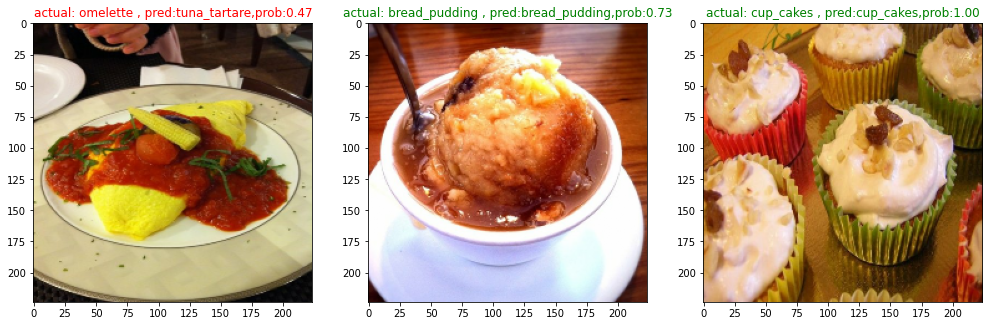

In [138]:
#Make preds on series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
    #Choose a random image(s) from a random class(es)
    class_name=random.choice(class_names)
    filename=random.choice(os.listdir(test_dir+"/"+class_name))
    filepath=test_dir+"/"+class_name+"/"+filename
    #print(filepath)
    
    #Load the image and make predictions
    img=load_and_prep_image(filepath,scale=False)
    #print(img.shape)
    image_expanded=tf.expand_dims(img,axis=0)
    #print(image_expanded.shape)
    pred_prob=model.predict(image_expanded)  #get prediction probabilies array
    pred_class =class_names[pred_prob.argmax()] #get highest prediction probability index and matches it  class names list
    #print(pred_class)
    
    #plot the image(s)
    plt.subplot(1,3,i+1)
    plt.imshow(img/255.)
    if class_name==pred_class: #if predicted class matches truth class, make text green
        title_color="g"
    else:
        title_color="r"
    plt.title(f"actual: {class_name} , pred:{pred_class},prob:{pred_prob.max():.2f}",c=title_color)
    #plt.axes(False);

#### finding the most wrong predictions

* A good way to inspect your model's performance is to view the wrong predictions with the highest prediction probability(or Highest loss)
* Can reveal insights such as:
    * data issues(wrong labels, e.g. model is right, label is wrong)
    * Confusing classes(get better/more diverse data)

To find ut where our model is moset wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method
2. create a pandas dataframe of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names
3. Use our DataFrame to find all the wrong predictions(where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions(have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.


In [146]:
#get all of the image file paths in the test dataset
filepaths=[]
for filepath in test_data_101_10_percent.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                                   shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [156]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df=pd.DataFrame({"img_path":filepaths,
                     "y_true":y_labels,
                     "y_pred":pred_classes,
                     "pred_conf":preds_probs.max(axis=1), #get the maximum prediction probabilities,
                     "y_true_classname":[class_names[i] for i in y_labels ],
                     "y_pred_classname":[class_names[i] for i in pred_classes]})

In [157]:
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent\\test\\apple_pie...       0      52   
1      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3      b'101_food_classes_10_percent\\test\\apple_pie...       0      80   
4      b'101_food_classes_10_percent\\test\\apple_pie...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25246  b'101_food_classes_10_percent\\test\\waffles\\...     100      16   
25247  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25248  b'101_food_classes_10_percent\\test\\waffles\\...     100      94   
25249  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847247        apple_pie                 gyoza  
1       0.963522        apple_pie             apple_pie  
2       0.959218        apple_pie             apple_pie  
3       0.656396        apple_pie  pulled_pork_sandwich  
4       0.365006        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972789          waffles               waffles  
25246   0.878751          waffles          cheese_plate  
25247   0.539205          waffles               waffles  
25248   0.504983          waffles  strawberry_shortcake  
25249   0.689742          waffles               waffles  

[25250 rows x 6 columns]

In [158]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"]=pred_df["y_true"]==pred_df["y_pred"]
pred_df.head(5)

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0      52   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0      80   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847247        apple_pie                 gyoza         False  
1   0.963522        apple_pie             apple_pie          True  
2   0.959218        apple_pie             apple_pie          True  
3   0.656396        apple_pie  pulled_pork_sandwich         False  
4   0.365006        apple_pie             prime_rib         False

In [159]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong=pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent\\test\\scallops\...      87      29   
231    b'101_food_classes_10_percent\\test\\apple_pie...       0     100   
15359  b'101_food_classes_10_percent\\test\\lobster_r...      61      53   
23539  b'101_food_classes_10_percent\\test\\strawberr...      94      83   
21400  b'101_food_classes_10_percent\\test\\samosa\\3...      85      92   
...                                                  ...     ...     ...   
8763   b'101_food_classes_10_percent\\test\\escargots...      35      41   
2663   b'101_food_classes_10_percent\\test\\bruschett...      10      61   
7924   b'101_food_classes_10_percent\\test\\donuts\\3...      31      29   
18586  b'101_food_classes_10_percent\\test\\peking_du...      74      39   
3519   b'101_food_classes_10_percent\\test\\carrot_ca...      14      21   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999982                 samosa           spring_rolls         False  
...          ...                    ...                    ...           ...  
8763    0.997165              escargots      french_onion_soup         False  
2663    0.997059             bruschetta  lobster_roll_sandwich         False  
7924    0.997043                 donuts              cup_cakes         False  
18586   0.996863            peking_duck              foie_gras         False  
3519    0.996843            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

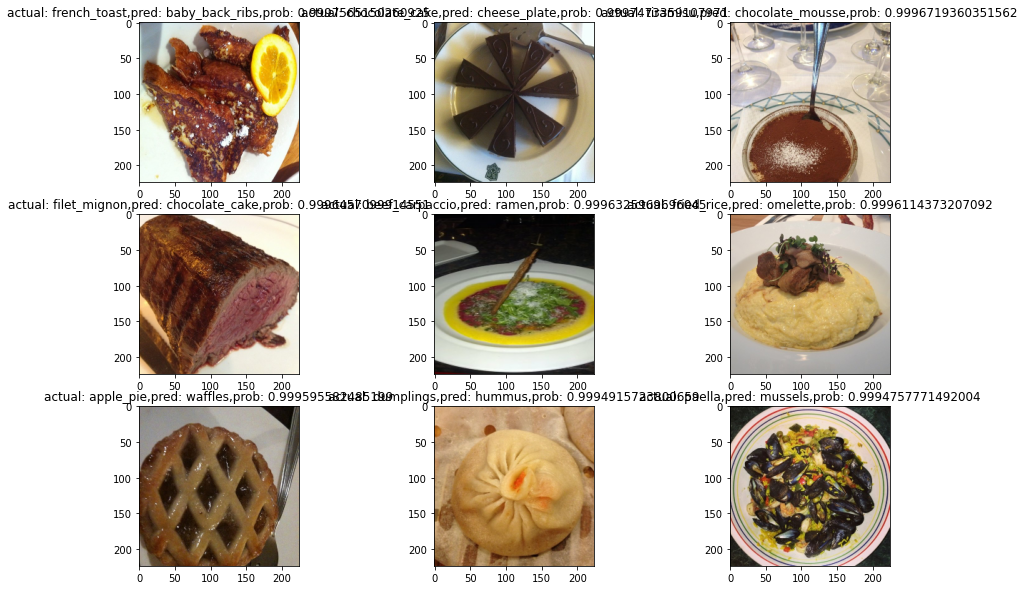

In [165]:
# 5. visualize the test data samples which have the wrong prediction but have highest pred probability

images_to_view=9
start_index=20
plt.figure(figsize=(15,10))
for i,row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    #print(row)
    plt.subplot(3,3,i+1)
    img=load_and_prep_image(row[1],scale=False)
    _,_,_,_,pred_prob,y_true_class_name,y_pred_class_name,_=row #only interested in a few parameters of each row
    plt.imshow(img/255.)
    plt.title(f"actual: {y_true_class_name},pred: {y_pred_class_name},prob: {pred_prob}")
    

#### making predictions on and ploting our own custom images

In [167]:
## test out the big dog model on our own custom images

#get custom images
url="https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip"
import wget
filename=wget.download(url)
unzip_data(filename)

100% [........................................................................] 13192985 / 13192985

In [168]:
#get the custom food images filepaths
custom_food_images=["custom_food_images/"+img_path for img_path in os.listdir("custom_food_images/")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg']

1/1 [==============================] - 0s 23ms/step


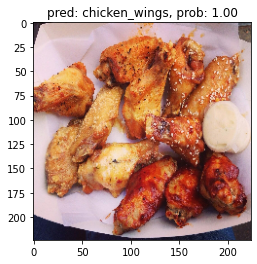

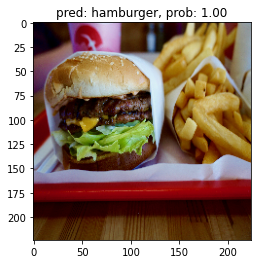

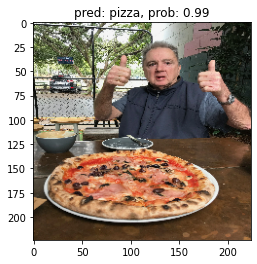

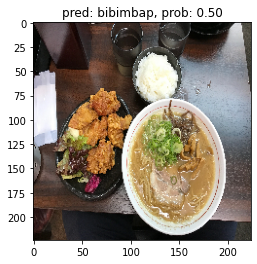

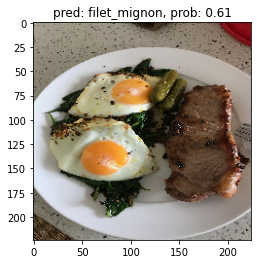

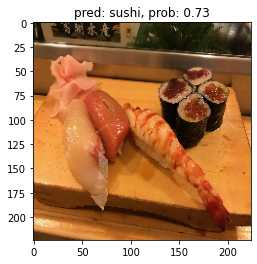

In [170]:
#make predictions on and plot custom food images
for img in custom_food_images:
    img=load_and_prep_image(img,scale=False)  #don't need to scale on EfficientnetB0 model
    pred_prob=model.predict(tf.expand_dims(img,axis=0))  #Make prediction on image with shape[1,224,224,3] same shape as model trained on
    pred_class=class_names[pred_prob.argmax()]  #get the index with the highest prediction probabilities
    #plot the appropriate information
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")